# Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

# Tools

In [187]:
def evaluate(model, X, y, X_test, y_test):
    model.fit(X, y)
    preds = model.predict(X_test)
    return np.sum(np.absolute(y_test - preds))

In [177]:
def timesplit(data):
    data['year'] = data.started_at.dt.year
    data['month'] = data.started_at.dt.month
    data['season'] = (data.started_at.dt.month % 12) // 3
    data['day'] = data.started_at.dt.day
    return data

In [31]:
def prepro(data, interval=None, baseline=False):
    """
    return data, train/test splits
    """
    #set datetime
    for cols in data.columns:
        if data[cols].dtypes == object:
            data[cols] = pd.to_datetime(data[cols])

    #remove fake records
    data = data[data.started_at.dt.year > 2022]

    #remove all users with only 1 record (28 days) & also with 2 becauuse we need to validate it somehow
    s = data.groupby(['user_id'])['count_of_days'].count() > 2
    data = data[data.user_id.isin(s[s].index)]

    #remove last record for every user
    if not baseline:
        data = data[data.groupby('user_id').cumcount(ascending=False) > 0]

    #keep users with a cycle in the interval
    if interval is not None:
        data = data[~data.user_id.isin(data[(data['count_of_days'] < interval[0]) | (data['count_of_days'] > interval[1])]['user_id'].unique())]

    test = data.groupby("user_id").last().reset_index()
    test = to_dict(test)
    train = data[data.groupby('user_id').cumcount(ascending=False) > 0]
    train = to_dict(train)

    #choose only modern data
    #december = data[(data.started_at.dt.month == 12) & (data.started_at.dt.year == 2023)].user_id.unique()
    #december_plus = data[data.started_at.dt.year == 2024].user_id.unique()
    #before_dec = data[(data.started_at.dt.year < 2024) & ~((data.started_at.dt.month == 12) & (data.started_at.dt.year == 2023))].user_id.unique()
    #data = data[data.user_id.isin(set.intersection(set(december), set(december_plus), set(before_dec)))]

    return data, train, test#data[data.started_at.dt.year < 2024], data[(data.started_at.dt.year == 2024) & (data.started_at.dt.month == 1)]

In [62]:
def preprocessing(data, baseline=False):
    """
    return preprocessed data - without synthetic records and predictions
    """

    data = data[['user_id', 'started_at', 'count_of_days']]
    #set datetime
    for cols in data.columns:
        if data[cols].dtypes == object:
            data[cols] = pd.to_datetime(data[cols])

    #remove fake records
    data = data[data.started_at.dt.year > 2022]

    #remove all users with only 1 record (28 days) & also with 2 because we need to validate it somehow
    s = data.groupby(['user_id'])['count_of_days'].count() > 2
    data = data[data.user_id.isin(s[s].index)]

    #remove last record for every user
    # TO DO test case
    if not baseline:
        data = data[data.groupby('user_id').cumcount(ascending=False) > 0]

    return data

def separation(data, interval=(18, 35), with_std=None, cv_quantile=0.5):
    """
    return data separated by (up to 4) groups
    """

    if with_std is not None:
        #data = data[~data.user_id.isin(data[(data['count_of_days'].std() > with_std[1]) | (data['count_of_days'].std() < with_std[0])]['user_id'].unique())]
        #s = data.groupby(['user_id'])['count_of_days'].std().between(with_std[0], with_std[1], inclusive=True)
        #data = data[data.user_id.isin(s[s].index)]
        s = data.groupby(['user_id'])['count_of_days'].std().between(with_std[0], with_std[1], inclusive=True)
        data = data[data.user_id.isin(s[s].index)]
        #std_ = data.count_of_days.std()
        #mean_ = data.count_of_days.mean()
        #data = data[(data.count_of_days > mean_ - std_) & (data.count_of_days < mean_ + std_)]
        s = data.groupby(['user_id'])['count_of_days'].count() > 1
        data = data[data.user_id.isin(s[s].index)]

    #keep users with a cycle in the interval
    data_0 = data[~data.user_id.isin(data[(data['count_of_days'] < interval[0]) | (data['count_of_days'] > interval[1])]['user_id'].unique())]
    data_1 = data[data.user_id.isin(data[(data['count_of_days'] < interval[0]) | (data['count_of_days'] > interval[1])]['user_id'].unique())]

    #print(data_0.user_id.nunique()/data.user_id.nunique(), data_1.user_id.nunique()/data.user_id.nunique(), data_0.user_id.nunique()/data.user_id.nunique() + data_1.user_id.nunique()/data.user_id.nunique())

    #coefficient of variation
    cv = (data.groupby(['user_id'])['count_of_days'].std() / data.groupby(['user_id'])['count_of_days'].mean()).quantile(q=cv_quantile)

    s_0 = (data_0.groupby(['user_id'])['count_of_days'].std() / data_0.groupby(['user_id'])['count_of_days'].mean()) < cv
    s_1 = (data_0.groupby(['user_id'])['count_of_days'].std() / data_0.groupby(['user_id'])['count_of_days'].mean()) >= cv

    data_0_0 = data_0[data_0.user_id.isin(s_0[s_0].index)]
    data_0_1 = data_0[data_0.user_id.isin(s_1[s_1].index)]

    #print(data_0_0.user_id.nunique()/data.user_id.nunique(), data_0_1.user_id.nunique()/data.user_id.nunique())

    s_0 = (data_1.groupby(['user_id'])['count_of_days'].std() / data_1.groupby(['user_id'])['count_of_days'].mean()) < cv
    s_1 = (data_1.groupby(['user_id'])['count_of_days'].std() / data_1.groupby(['user_id'])['count_of_days'].mean()) >= cv

    data_1_0 = data_1[data_1.user_id.isin(s_0[s_0].index)]
    data_1_1 = data_1[data_1.user_id.isin(s_1[s_1].index)]

    #print(data_1_0.user_id.nunique()/data.user_id.nunique(), data_1_1.user_id.nunique()/data.user_id.nunique())

    #choose only modern data
    #december = data[(data.started_at.dt.month == 12) & (data.started_at.dt.year == 2023)].user_id.unique()
    #december_plus = data[data.started_at.dt.year == 2024].user_id.unique()
    #before_dec = data[(data.started_at.dt.year < 2024) & ~((data.started_at.dt.month == 12) & (data.started_at.dt.year == 2023))].user_id.unique()
    #data = data[data.user_id.isin(set.intersection(set(december), set(december_plus), set(before_dec)))]
    #data[data.started_at.dt.year < 2024], data[(data.started_at.dt.year == 2024) & (data.started_at.dt.month == 1)]

    return data_0_0, data_0_1, data_1_0, data_1_1

In [4]:
def round_cycle(length):
    if length > 28:
        return int(length)
    elif length == 28:
        return length
    else:
        if length - int(length) > 0:
            return int(length) + 1
        else:
            return length

In [5]:
def wrapper(model, data, window=False, interval=None):
    if (len(data) > 2 and window):
        data = data[-3:]
    if interval is not None:
        data = data[(data > interval[0]-1) & (data < interval[0]+1)]
    if len(data) == 0:
            return 28
    elif len(data) == 1:
        return data[0]
    else:
        return round_cycle(model(data))

In [6]:
def arima(data):
    model = ARIMA(data, order = (3, 0, 1)).fit()
    return model.forecast()

In [7]:
def sarimax(data):
    model = SARIMAX(data).fit()
    return model.forecast()

In [8]:
def avg(data):
    return data.mean()

In [9]:
def baseline(cycle):
        return cycle.mean()

In [186]:
def validation(train, val, model, window=True):
    result = {}
    #i = 0
    for id in train:
        result[id] = wrapper(model, train[id], window)
        #i+=1
        #if (i % 100 == 0): print(i)

    test = np.fromiter(val.values(), dtype=int)
    pred = np.fromiter(result.values(), dtype=int)

    return np.sum(np.absolute(test - pred))

In [11]:
def to_dict(data_):
    cycle = {}
    for elem in data_.sort_values(by=['user_id', 'started_at'])[['user_id', 'count_of_days']].groupby('user_id'):
        cycle[elem[0]] = elem[1]['count_of_days'].values
    return cycle

In [12]:
def optimal_search(model):
    mae = {}
    for i in range(10, 20):
        for j in range(40, 50):
            _, train, val = prepro(df, interval=(i, j))
            mae[(i,j)] = validation(train, val, model, window=True)
            print((i, j), mae[(i, j)])
    return mae

In [166]:
def train_test_split_(data):
    return data[data.groupby('user_id').cumcount(ascending=False) > 0], data.groupby("user_id").last().reset_index()

# EDA

## Overview

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df = pd.read_csv("/content/drive/MyDrive/Clatch/cycles.csv")

In [15]:
print('Number of entries: ', df.shape[0])
print('Number of entries in range 15-45 ', df[(df['count_of_days'] > 14) & (df['count_of_days'] < 46)].shape[0])
print('Number of unique users: ', df['user_id'].nunique())
print('Number of unique users with all cycles in range 15-45: ', df['user_id'].nunique() - df[(df['count_of_days'] < 15) | (df['count_of_days'] > 45)]['user_id'].nunique())

Number of entries:  663652
Number of entries in range 15-45  622316
Number of unique users:  177860
Number of unique users with all cycles in range 15-45:  146003


In [18]:
df.head()

,id,user_id,started_at,ended_at,monthlies_started_at,monthlies_ended_at,fertile_started_at,ovulation_at,fertile_ended_at,count_of_days,created_at,updated_at
0,42793,4182,2023-03-06,2023-03-07,2023-03-06,2023-03-06,2023-03-22,2023-03-22,2023-03-22,2,2023-03-22 04:01:36,2023-03-22 04:01:36
1,42794,4182,2023-03-08,2023-03-12,2023-03-08,2023-03-11,2023-03-22,2023-03-22,2023-03-22,5,2023-03-22 04:01:36,2023-03-22 04:01:36
2,42795,4182,2023-03-13,2023-04-10,2023-03-13,2023-03-13,2023-03-23,2023-03-28,2023-03-29,29,2023-03-22 04:01:36,2023-03-22 04:01:36
3,97093,9926,2023-03-29,2023-04-17,2023-03-29,2023-03-29,2023-03-29,2023-04-03,2023-04-04,20,2023-05-21 19:32:55,2023-05-21 19:32:55
4,97094,9926,2023-04-18,2023-05-07,2023-04-18,2023-04-20,2023-04-18,2023-04-23,2023-04-24,20,2023-05-21 19:32:55,2023-05-21 19:32:55


## Stats

In [43]:
data = preprocessing(df)

In [44]:
counts = dict()
for i in np.array(data["count_of_days"]):
    if (i > 9 and i < 51):
        counts[i] = counts.get(i, 0) + 1

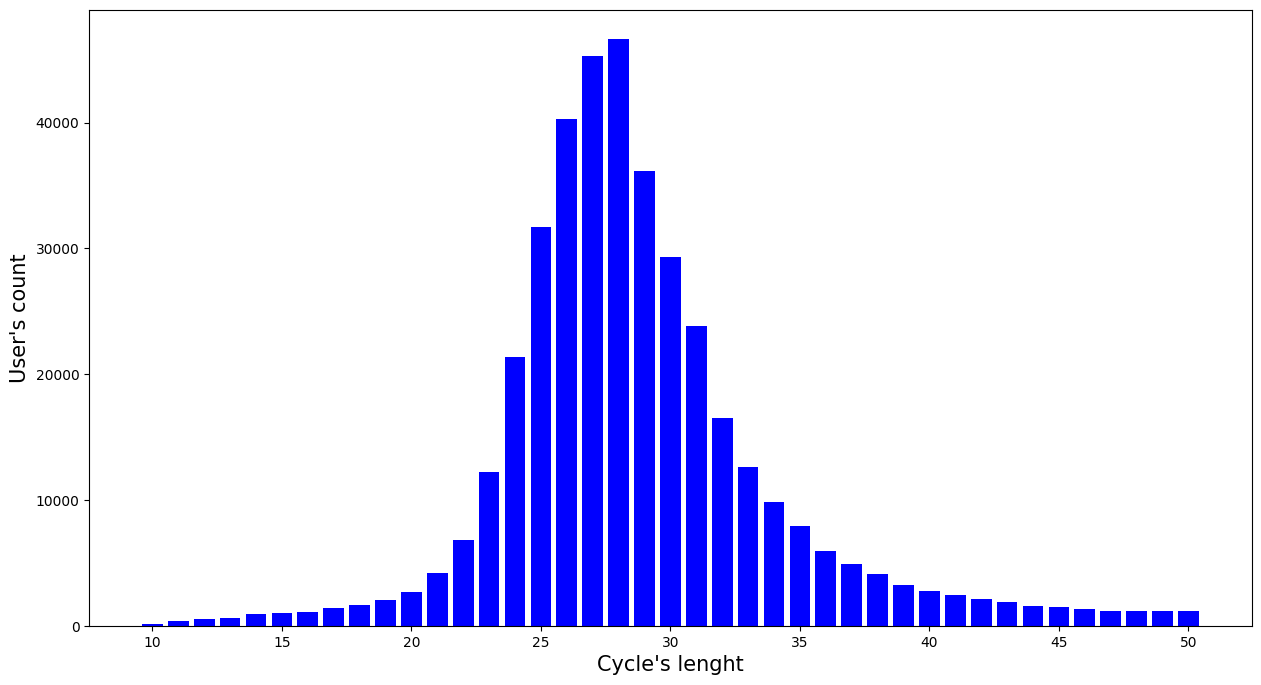

In [45]:
plt.rcParams["figure.figsize"] = (15,8)
plt.bar(list(counts.keys()), counts.values(), color='b')
plt.xlabel('Cycle\'s lenght', size=15)
plt.ylabel('User\'s count', size=15)
plt.show()

In [46]:
data.count_of_days.describe()

count    416452.000000
mean         31.380325
std          14.980285
min           2.000000
25%          26.000000
50%          28.000000
75%          32.000000
max         384.000000
Name: count_of_days, dtype: float64

А) Данные смещены относительно ожидаемого значения 28 на 3.4

B) Отклонение 15, что много;(

Распределение максимально соответствует нормальному для циклов в интервале $[18, 35]$.

In [35]:
data_normal, _, _ = prepro(df, interval=(18, 35))

In [36]:
counts = dict()
for i in np.array(data_normal["count_of_days"]):
    counts[i] = counts.get(i, 0) + 1

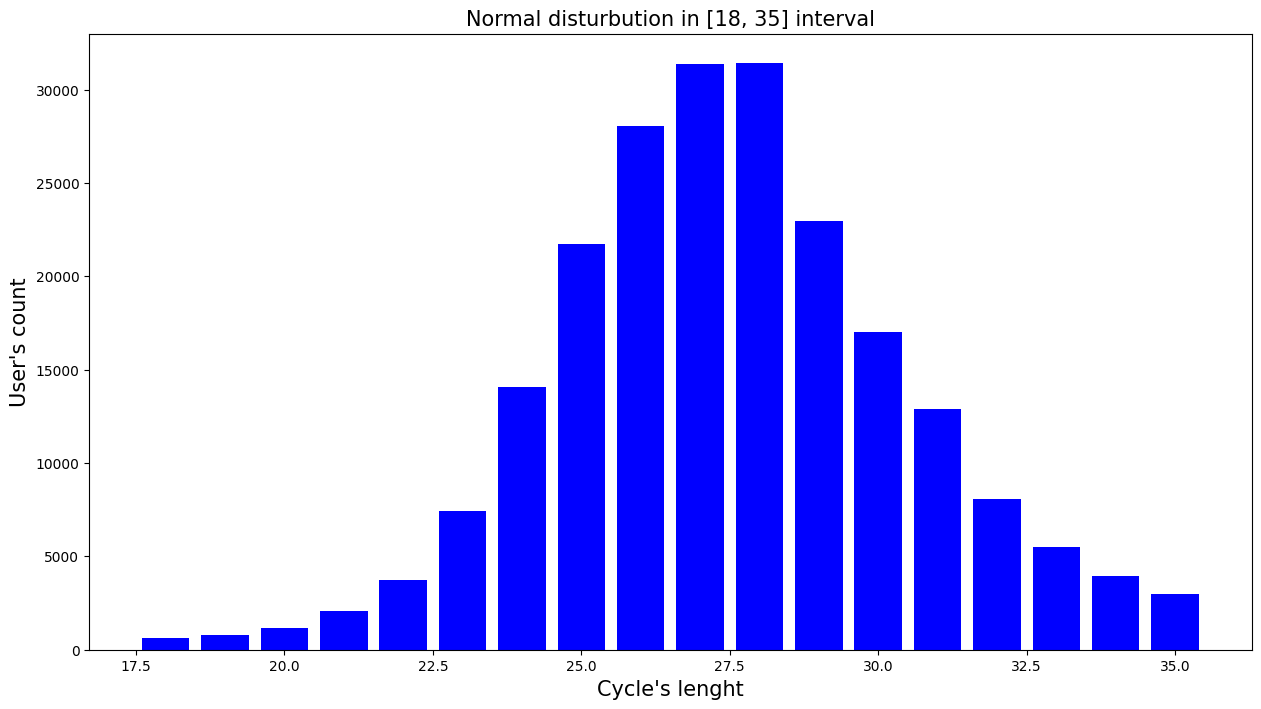

In [42]:
plt.rcParams["figure.figsize"] = (15,8)
plt.bar(list(counts.keys()), counts.values(), color='b')
plt.xlabel('Cycle\'s lenght', size=15)
plt.ylabel('User\'s count', size=15)
plt.title('Normal disturbution in [18, 35] interval', size=15)
plt.show()

Далее разобьем данные на 4 группы по 2м критериям:

1. Принадлежность к интервалу $[18, 35]$.
2. 0.5 квантиль коэффициента вариации.

In [69]:
data_0_0, data_0_1, data_1_0, data_1_1 = separation(data, cv_quantile=0.5)

In [70]:
print(f'Group 1: in intervale/in quantile\nPercentage of all data: {data_0_0.user_id.nunique()/data.user_id.nunique()}')
print(f'Group 2: in intervale/out of quantile\nPercentage of all data: {data_0_1.user_id.nunique()/data.user_id.nunique()}')
print(f'Group 3: out of intervale/in quantile\nPercentage of all data: {data_1_0.user_id.nunique()/data.user_id.nunique()}')
print(f'Group 4: out of intervale/out of quantile\nPercentage of all data: {data_1_1.user_id.nunique()/data.user_id.nunique()}')

Group 1: in intervale/in quantile
Percentage of all data: 0.4506431042588329
Group 2: in intervale/out of quantile
Percentage of all data: 0.0802343382716347
Group 3: out of intervale/in quantile
Percentage of all data: 0.04926648745735743
Group 4: out of intervale/out of quantile
Percentage of all data: 0.419856070012175


# Models

## Baseline

In [ ]:
data, train, val = prepro(df, baseline=True)

In [ ]:
validation(train, val, baseline, window=True)

0.10171095740808155

## Валидация

In [179]:
data = preprocessing(df)
data = timesplit(data)

In [180]:
data_0_0, data_0_1, data_1_0, data_1_1 = separation(data, cv_quantile=0.5)

In [181]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, ['season']),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [195]:
min_mae = 0
mae_baseline = 0
res = np.array([])

for dataset in [data_0_0, data_0_1, data_1_0, data_1_1]:
    train, test = train_test_split_(dataset)

    #data for sklearn models
    X = train[['year', 'month', 'season', 'day']]
    y = train['count_of_days']
    X_test = test[['year', 'month', 'season', 'day']]
    y_test = test['count_of_days']

    #data for custom models
    train = to_dict(train)
    test = to_dict(test)

    # moving avg
    mae_mavg_all = validation(train, test, baseline, window=True)
    # avg
    mae_avg_all = validation(train, test, baseline, window=False)
    # Ridge
    mae_ridge = evaluate(naive_linear_pipeline, X, y, X_test, y_test)

    res = np.append(res, [mae_mavg_all, mae_avg_all, mae_ridge])
    min_mae+=min([mae_mavg_all, mae_avg_all, mae_ridge])
    mae_baseline+=mae_mavg_all

    #print(mae_mavg_all, mae_avg_all, mae_ridge)

Our: 6.9051887983208085 vs Baseline: 9.26969393782321


In [207]:
cols = ['MAvg', 'Avg', 'Ridge']
datas = ['Normal/Quantile', 'Normal/Not Quantile', 'Not Normal/Quantile', 'Not Normal/Not Quantile']
result = pd.DataFrame(data=res.reshape(4, 3), index=datas, columns=cols)
result.index.name = 'AE'

print(result)
print(f'\nMAE:\nOur: {min_mae / data.user_id.nunique()} vs \nBaseline: {mae_baseline / data.user_id.nunique()}')

                             MAvg       Avg          Ridge
AE                                                        
Normal/Quantile           65827.0   64571.0   86254.318025
Normal/Not Quantile       33567.0   33250.0   23924.131596
Not Normal/Quantile       12770.0   12495.0   28205.369297
Not Normal/Not Quantile  656822.0  662120.0  471843.615546

MAE:
Our: 6.9051887983208085 vs 
Baseline: 9.26969393782321
